Importa o modelo a ser fatiado e mapeado

In [6]:
import matplotlib.pyplot as plt
import gui
import files
from timer import Timer
from components.layer import Layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
choice = gui.ask_load_or_begin()
if choice == "Novo Projeto":
    path_input, file_name = gui.load_model(folders)
    [dpi, layer_height] = gui.ask_parameters_input()
    with Timer("Fase 0: "):
        Layer.create_layers(folders, path_input, file_name, dpi, layer_height)
elif choice == "Carregar Salvo":
    gui.find_saved_file(folders)
elif choice == "Cancelar":
    quit

#TODO: encontrar uma forma de jogar layerHight para o slicing W/images (POSSIVELMENTE COM O RUNSINGLEMODEL)

Paredes Finas

In [7]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[nozzle_diam_internal,nozzle_diam_external] = gui.ask_parameters_thin_walls()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 1: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_thin_walls(folders, nozzle_diam_external, nozzle_diam_internal)
        %reset_selective -f "c"
%reset_selective -f "camadas"
# TODO: arvore de paredes finas
# TODO: quando duas áreas se encontram
# TODO: limite de parede diam minimo
# TODO arrumar para origens extremamente pequenas, ignorar da problema
# TODO arrumar casos onde a beirada esta vazndo criando areas triangulares distantes
# FIXME: Precisa mesmo separar linha 1 2 topo e baixo? muitos elementos estão sendo criados

Fase 1: Camada: 0
Criando paredes finas
Total de [Criando paredes finas] : 3.600635290145874
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.0009305477142333984
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.041291236877441406
Total de [Fase 1: Camada: 0] : 3.680673599243164
Fase 1: Camada: 1
Criando paredes finas
Total de [Criando paredes finas] : 4.450414180755615
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.0005533695220947266
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.02584218978881836
Total de [Fase 1: Camada: 1] : 4.5177366733551025
Fase 1: Camada: 2
Criando paredes finas
Total de [Criando paredes finas] : 4.574151277542114
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.0010004043579101562
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.03493332862854004
Total de [Fase 1: Camada: 2] : 4.654191

Contornos

In [8]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[void_max,internal_max,external_max] = gui.ask_parameters_offsets()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 2: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_offsets(folders, void_max, external_max, internal_max)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 2: Camada: 0
Criando Lvls
Ilha: I_000 Número de Níveis: 5
Total de [Criando Lvls] : 3.223578929901123
Criando os loops
Total de [Criando os loops] : 1.3523650169372559
Criando regiões de influência
Total de [Criando regiões de influência] : 0.1541132926940918
Criando as regiões de Offset
Total de [Criando as regiões de Offset] : 1.7138581275939941
Retirando regiões da camada
['Lvl_000', 0, 0] Perdendo total:622 maior void:0.32852386237513875Bw -> aceito
['Lvl_000', 1, 0] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_000', 1, 1] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_001', 0, 0] Perdendo total:72672 maior void:78.2597114317425Bw -> bloqueado
['Lvl_002', 0, 0] Perdendo total:11852 maior void:5.847946725860155Bw -> bloqueado
['Lvl_003', 0, 0] Perdendo total:11285 maior void:5.700332963374029Bw -> bloqueado
['Lvl_004', 0, 0] Perdendo total:5394 maior void:2.591564927857936Bw -> bloqueado
['Lvl_001', 0, 1] Perdendo total:15883 maior void:8.793562708102108Bw -> bloqueado
['Lv

Pontes

In [9]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd
import numpy as np
from components import images_tools as it

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[n_max, nozzle_diam_internal] = gui.ask_parameters_bridges()
camadas = folders.load_layers_hdf5()
last_prohibited_areas = np.zeros(camadas[0].base_frame)
for i,c in enumerate(camadas):
    with Timer("Fase 3: Camada: " + str(i)):
        if i%2 == 1:
            last_image = it.rotate_img_cw(last_prohibited_areas )
        elif i%2 == 0:
            last_image = it.rotate_img_ccw(last_prohibited_areas )
        if i >= 2:
            if i%2 == 1:
                second_last_image = it.rotate_img_cw(camadas[i - 1].prohibited_areas)
            elif i%2 == 0:
                second_last_image = it.rotate_img_ccw(camadas[i - 1].prohibited_areas)
        else:
            second_last_image = np.zeros_like(last_image)
        c.prohibited_areas = last_image
        sum_prohibited_areas = it.sum_imgs([last_image, second_last_image])
        last_prohibited_areas = c.make_bridges(n_max, nozzle_diam_internal, folders, len(camadas), sum_prohibited_areas)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        # %reset_selective -f "c" 
%reset_selective -f "camadas"

Fase 3: Camada: 0
Criando pontes de Offset
Total de [Criando pontes de Offset] : 2.1519808769226074
Criando pontes de Zigzag
Fechou uma ponte OK
Fechou uma ponte OK
Total de [Criando pontes de Zigzag] : 8.939647436141968
Criando pontes de Crossover
Elemento: ('Reg_000', 'Reg_001') Maior prioridade: 0
Elemento: ('Reg_000', 'Reg_002') Maior prioridade: 1
Total de [Criando pontes de Crossover] : 0.05189943313598633
Retirando pontes da Camada
Total de [Retirando pontes da Camada] : 0.019099712371826172
Gerando áreas proibidas
Total de [Gerando áreas proibidas] : 0.0013189315795898438
salvando imagens das regiões
deletado: /L_000/I_000/bridges
Total de [salvando imagens das regiões] : 0.2833573818206787
Total de [Fase 3: Camada: 0] : 11.539404153823853
Fase 3: Camada: 1
Criando pontes de Offset
Total de [Criando pontes de Offset] : 2.6150810718536377
Criando pontes de Zigzag
Fechou uma ponte OK
Fechou uma ponte OK
Total de [Criando pontes de Zigzag] : 8.527084827423096
Criando pontes de Cro

Zigzags

In [10]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        c.make_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"


Fase 4: Camada: 0
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 4.069811105728149
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.03726840019226074
Total de [Fase 4: Camada: 0] : 4.232772588729858
Fase 4: Camada: 1
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 0.7608461380004883
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.02163219451904297
Total de [Fase 4: Camada: 1] : 0.934478759765625
Fase 4: Camada: 2
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 3.850886344909668
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.037636756896972656
Total de [Fase 4: Camada: 2] : 4.009193658828735
Fase 4: Camada: 3
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 0.7354631423950195
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.021721363067626953
Total de [Fase 4: Camada: 3] : 0.8812096118927002

Fase 4: Camada: 0


Total de [Fase 4: Camada: 0] : 0.42658281326293945
Fase 4: Camada: 1


Total de [Fase 4: Camada: 1] : 0.3417370319366455
Fase 4: Camada: 2


Total de [Fase 4: Camada: 2] : 0.33844733238220215
Fase 4: Camada: 3


Total de [Fase 4: Camada: 3] : 0.34366583824157715
Fase 4: Camada: 4


Total de [Fase 4: Camada: 4] : 0.35628581047058105
Fase 4: Camada: 5


Total de [Fase 4: Camada: 5] : 0.4714994430541992
Fase 4: Camada: 6


Total de [Fase 4: Camada: 6] : 0.34198904037475586
Fase 4: Camada: 7


Total de [Fase 4: Camada: 7] : 0.34538698196411133
Fase 4: Camada: 8


Total de [Fase 4: Camada: 8] : 0.3445701599121094
Fase 4: Camada: 9


Total de [Fase 4: Camada: 9] : 0.339841365814209


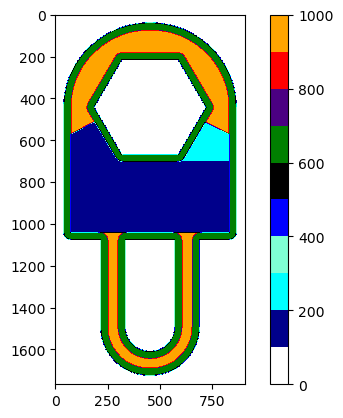

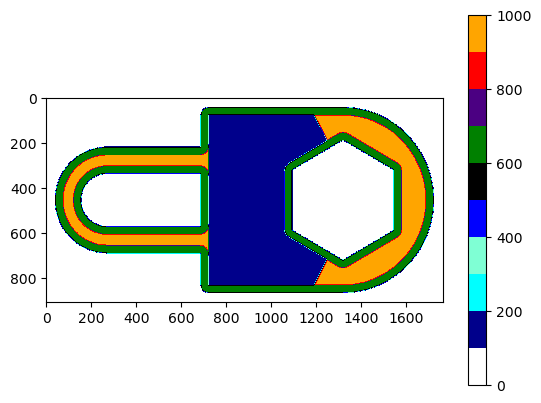

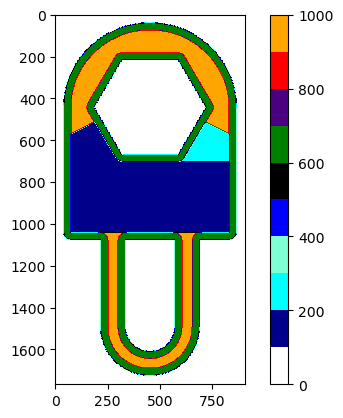

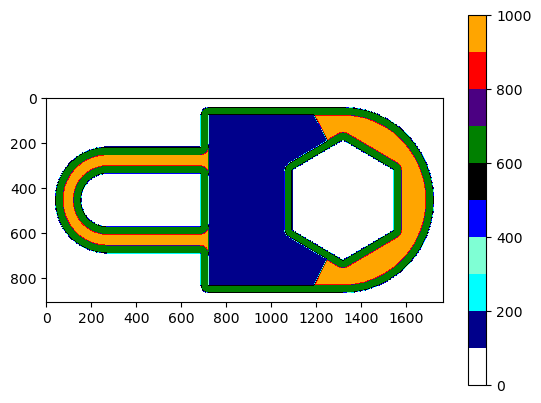

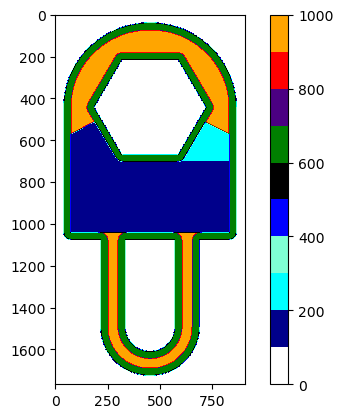

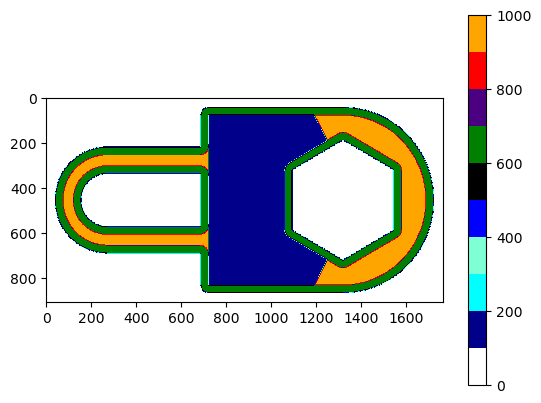

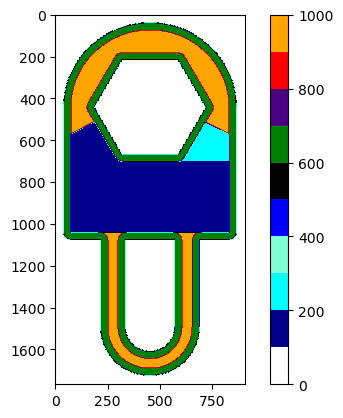

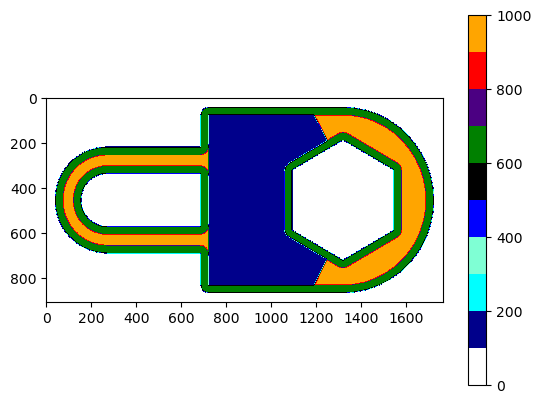

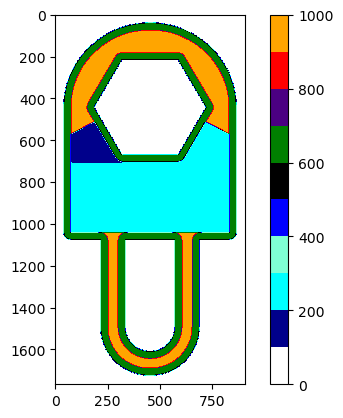

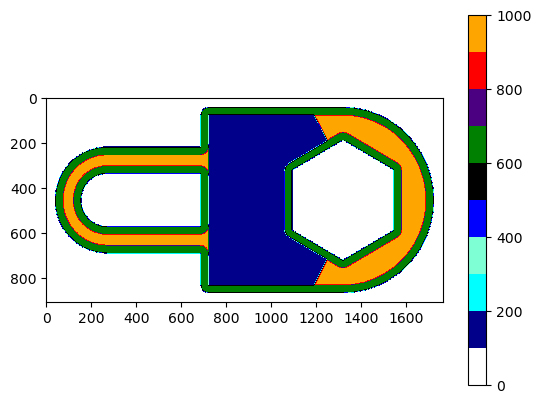

In [11]:
import gui
import files
from timer import Timer
from components import images_tools as it
from os import getcwd
import matplotlib.pyplot as plt
import matplotlib.colors
import os

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for c in camadas:
    folders.load_islands_hdf5(c)
tangran_cmap = matplotlib.colors.ListedColormap(["white","darkblue","aqua","aquamarine","blue","black","green","indigo","red","orange"])
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        plt.figure()
        img_mapping = it.final_mapping(c, folders)
        # if i%2 == 1:
        #     img_mapping = it.rotate_img_ccw(img_mapping )
        plt.imshow(img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.imsave("aaa.png",img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.colorbar()
        print('\n')

ROTAS

Rotas de Offset

In [12]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

amendment_size = 0.7 #porcentagem do tamanho da poca de deposicao de material
for c in camadas:
    with Timer("Making offset routes"):
        c.make_offset_routes(amendment_size, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.11228060722351074
Total de [Making offset routes] : 4.146183013916016
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.09314942359924316
Total de [Making offset routes] : 3.5196688175201416
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.12480854988098145
Total de [Making offset routes] : 3.56327486038208
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.09868550300598145
Total de [Making offset routes] : 3.6325631141662598
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.12254047393798828
Total de [Making offset routes] : 3.763720750808716
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.13499951362609863
Total de [Making offset routes] : 3.9497532844543457
Making offset routes
salvando imagens 

Rotas de pontes

In [13]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Making bridges routes"):
        c.make_bridges_routes(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.21598315238952637
Total de [Making bridges routes] : 13.506367921829224
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.1809399127960205
Total de [Making bridges routes] : 13.199913263320923
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.21918177604675293
Total de [Making bridges routes] : 13.359796285629272
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.2095046043395996
Total de [Making bridges routes] : 13.119689464569092
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.2583796977996826
Total de [Making bridges routes] : 13.519249439239502
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.20901823043823242
Total de [Making bridges routes] : 13.373584508895874
Making bridges routes
sal

Rotas de Ziguezague

In [14]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Making zigzag routes"):
        c.make_zigzag_routes(folders)
        c.connect_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"



Making zigzag routes
criando as rotas de zigzag, camada:L_000
fazendo as tres opções:
Total de [fazendo as tres opções:] : 15.802312135696411
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.5256624221801758
fazendo as tres opções:
Total de [fazendo as tres opções:] : 15.781578779220581
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.532799243927002
Total de [criando as rotas de zigzag, camada:L_000] : 35.33590626716614
salvando imagens das rotas
deletado: /L_000/I_000/zigzags
Total de [salvando imagens das rotas] : 0.09351277351379395
Criando os grafos de regiões
Total de [Criando os grafos de regiões] : 0.012217044830322266
Conectando regiões de zigzag
Total de [Conectando regiões de zigzag] : 0.0021648406982421875
salvando grafos
Total de [salvando grafos] : 0.1616811752319336
Total de [Making zigzag routes] : 36.0024778842926
Making zigzag routes
criando as rotas de zigzag, camada:L_001
fazendo as tres opções:
Total de [fazendo as tres opções:] : 8.36589717

WEAVING

In [15]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
[iwflag] = gui.ask_parameters_weaving()
for c in camadas:
    with Timer("Fase 5 b"):
        c.internal_weaving(iwflag, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5 b
gerando preenchimentos oscilatórios
Pegando as falhas internas
Total de [Pegando as falhas internas] : 0.5042324066162109
Achando os contatos
Total de [Achando os contatos] : 2.7196195125579834
criando os weavings
sequncia corrigida, b e c trocado
sequncia corrigida, b e c trocado
Total de [criando os weavings] : 1.693328619003296
Total de [gerando preenchimentos oscilatórios] : 7.502732038497925
salvando rotas
deletado: /L_000/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.1798398494720459
Total de [Fase 5 b] : 7.683216094970703
Fase 5 b
gerando preenchimentos oscilatórios
Pegando as falhas internas
Total de [Pegando as falhas internas] : 0.35573410987854004
Achando os contatos
Total de [Achando os contatos] : 1.2209362983703613
criando os weavings
Total de [criando os weavings] : 1.494250774383545
Total de [gerando preenchimentos oscilatórios] : 5.289168119430542
salvando rotas
deletado: /L_001/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.1482107639312744

Rotas de Thin Walls

In [16]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Fase 5"):
        with Timer("Making thin walls routes"):
            c.make_thin_wall_routes(folders)
            %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.04234147071838379
salvando imagens das rotas
Total de [salvando imagens das rotas] : 7.152557373046875e-06
Total de [Making thin walls routes] : 0.04265427589416504
Total de [Fase 5] : 0.04279041290283203
Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.036179542541503906
salvando imagens das rotas
Total de [salvando imagens das rotas] : 7.867813110351562e-06
Total de [Making thin walls routes] : 0.03645968437194824
Total de [Fase 5] : 0.036481380462646484
Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.04001760482788086
salvando imagens das rotas
Total de [salvando imagens das rotas] : 6.4373016357421875e-06
Total de [Making thin walls routes] : 0.040320396423339844
Total de [Fase 5] : 0.040343284606933594
Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.035294532775878906
salvando imagens das rotas
Total de [

Unificando rotas EXTERNAS nas camadas

In [17]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 6"):
        c.close_routes_external(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"
    

Fase 6
Conectando rotas externas
Conectando pontes de Offset
Total de [Conectando pontes de Offset] : 0.3669257164001465
Conectando pontes de Crossover
salto:  [480, 719]
salto:  [1080, 587]
Total de [Conectando pontes de Crossover] : 0.7441282272338867
Total de [Conectando rotas externas] : 1.511122226715088
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.14576053619384766
Total de [Fase 6] : 1.657442331314087
Fase 6
Conectando rotas externas
Conectando pontes de Offset
Total de [Conectando pontes de Offset] : 0.2647979259490967
Conectando pontes de Crossover
salto:  [319, 686]
salto:  [187, 1286]
Total de [Conectando pontes de Crossover] : 0.7450411319732666
Total de [Conectando rotas externas] : 1.37013578414917
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.13020706176757812
Total de [Fase 6] : 1.5006687641143799
Fase 6
Conectando rotas externas
Conectando pontes de Offset
Total de [Conectando pontes de Offset] : 0.2691681385040283
Conecta

Unificando rotas INTERNAS nas camadas

In [18]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 7"):
        c.close_routes_internal(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 1.9857006072998047
Conectando pontes de zigzag
Total de [Conectando pontes de zigzag] : 0.002627134323120117
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.11447024345397949
Total de [Fase 7] : 2.5117027759552
Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 1.681748867034912
Conectando pontes de zigzag
Total de [Conectando pontes de zigzag] : 0.002524852752685547
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.11728715896606445
Total de [Fase 7] : 2.163900136947632
Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 1.7145483493804932
Conectando pontes de zigzag
Total de [Conectando pontes de zigzag] : 0.0024878978729248047
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.11242985725402832
Total de [Fase 7] : 2.2132091522216797
Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 1.7

Unindo rotas de thin walls

In [19]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 8"):
        c.close_routes_thinwalls(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0010352134704589844
salvando imagens das rotas
deletado: /L_000/I_000/thinwalls_tree_route/sequence
deletado: /L_000/I_000/thinwalls_tree_route/saltos
Total de [salvando imagens das rotas] : 0.13237857818603516
Total de [Fase 8] : 0.1870565414428711
Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0012919902801513672
salvando imagens das rotas
deletado: /L_001/I_000/thinwalls_tree_route/sequence
deletado: /L_001/I_000/thinwalls_tree_route/saltos
Total de [salvando imagens das rotas] : 0.09763193130493164
Total de [Fase 8] : 0.1382901668548584
Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0009202957153320312
salvando imagens das rotas
deletado: /L_002/I_000/thinwalls_tree_route/sequence
deletado: /L_002/I_000/thinwalls_tree_route/saltos
Total de [salvando imagens das rotas] : 0.1121211051940918
Total de [Fase 8] : 0.15360355377197266
Fase 8
Convertendo paredes f

Unindo todas as rotas

In [20]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    c.close_final_path(folders)

%reset_selective -f "camadas"


Encontrando ponto de união ext-int
Total de [Encontrando ponto de união ext-int] : 0.4802401065826416
Conectando todas as partes
Total de [Conectando todas as partes] : 0.01604938507080078
salvando imagens das rotas
[[984, 57], [1044, 57], [1045, 58], [1049, 58], [1050, 59], [1052, 59], [1059, 66], [1059, 68], [1060, 69], [1060, 73], [1061, 74], [1061, 206], [0, 0], [1080, 587], [1068, 582], [1063, 576], [1061, 568], [1061, 338], [1066, 326], [1075, 320], [1504, 319], [1519, 321], [1557, 334], [1577, 348], [1604, 377], [1616, 398], [1623, 420], [1627, 444], [1627, 463], [1623, 487], [1616, 508], [1604, 529], [1578, 557], [1558, 571], [1538, 580], [1515, 586], [1081, 587], [1070, 634], [1080, 632], [1143, 632], [1145, 628], [1189, 628], [1191, 632], [1235, 632], [1237, 628], [1281, 628], [1283, 632], [1327, 632], [1329, 628], [1373, 628], [1375, 632], [1419, 632], [1421, 628], [1465, 628], [1467, 632], [1508, 631], [1512, 627], [1531, 624], [1553, 617], [1559, 619], [1596, 598], [1594, 

Gerando o Código G

In [29]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[vel_int, vel_ext, vel_thin_wall, p_religamento, p_desligamento, vel_vazio, p_entre_camadas, substratoy, substratox, cortey, cortex] = gui.ask_parameters_Gcode()
coords_substrato = [substratoy, substratox]
coords_corte = [cortey, cortex]
camadas = folders.load_layers_hdf5()

#layer_heights = [10+2.9+3+(i*1.5) for i,x in enumerate(camadas)]
layer_heights = [20+8+2+(i*1.5) for i,x in enumerate(camadas)]
with Timer("Cuspindo o Gcode"):
    path_tools.layers_to_Gcode(camadas, 
                               folders, 
                               vel_int,
                               vel_ext, 
                               vel_thin_wall, 
                               p_religamento,
                               p_desligamento,
                               vel_vazio,
                               p_entre_camadas,
                               layer_heights,
                               coords_substrato,
                               coords_corte,
                               )
%reset_selective -f "camadas"

Cuspindo o Gcode
nome: L_000/I_000
[[984, 57], [1044, 57], [1045, 58], [1049, 58], [1050, 59], [1052, 59], [1059, 66], [1059, 68], [1060, 69], [1060, 73], [1061, 74], [1061, 206], [0, 0], [1080, 587], [1068, 582], [1063, 576], [1061, 568], [1061, 338], [1066, 326], [1075, 320], [1504, 319], [1519, 321], [1557, 334], [1577, 348], [1604, 377], [1616, 398], [1623, 420], [1627, 444], [1627, 463], [1623, 487], [1616, 508], [1604, 529], [1578, 557], [1558, 571], [1538, 580], [1515, 586], [1081, 587], [1070, 634], [1080, 632], [1143, 632], [1145, 628], [1189, 628], [1191, 632], [1235, 632], [1237, 628], [1281, 628], [1283, 632], [1327, 632], [1329, 628], [1373, 628], [1375, 632], [1419, 632], [1421, 628], [1465, 628], [1467, 632], [1508, 631], [1512, 627], [1531, 624], [1553, 617], [1559, 619], [1596, 598], [1594, 595], [1604, 588], [1627, 564], [1629, 567], [1641, 552], [1656, 522], [1664, 498], [1668, 473], [1668, 434], [1666, 421], [1663, 418], [1656, 393], [1658, 391], [1656, 383], [1638,

In [22]:
# import numpy as np
# camadas = folders.load_layers_hdf5()
# for c in camadas:
#     folders.load_islands_hdf5(c)
#     for isl in c.islands:
#         folders.load_island_paths_hdf5(c.name, isl)
#         internal_trees = [list(x) for x in isl.internal_tree_route.sequence]
#         print(internal_trees)
# print([235,807] in internal_trees)

In [23]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# # Lista de imagens binárias (exemplo com arrays numpy)
# imagens = [
#     img_mapping,
#     img_mapping,
#     img_mapping
# ]

# # Lista de alturas no eixo z
# alturas = [0, 10, 20]

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# for img, z in zip(imagens, alturas):
#     x = np.linspace(0, img.shape[1], img.shape[1])
#     y = np.linspace(0, img.shape[0], img.shape[0])
#     x, y = np.meshgrid(x, y)
#     z = np.full_like(x, z)
#     ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(img), shade=False)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.show()


In [24]:
# import gui
# import files
# from timer import Timer
# from components import layer, path_tools
# from os import getcwd

# if not('folders' in globals()):
#     home = getcwd()
#     folders = files.System_Paths(home)
#     gui.find_saved_file(folders)
# camadas = folders.load_layers_hdf5()

# file_name = gui.find_saved_file(folders)
# path_tools.layers_to_Gcode_FFF(camadas, folders, file_name)

In [25]:
# class TrafficLightState:
#     """Base class for traffic light states."""
#     def change(self, traffic_light):
#         raise NotImplementedError("This method should be overridden by subclasses")


# class RedState(TrafficLightState):
#     """State representing the red light."""
#     def change(self, traffic_light):
#         print("Changing from Red to Green")
#         traffic_light.state = GreenState()


# class YellowState(TrafficLightState):
#     """State representing the yellow light."""
#     def change(self, traffic_light):
#         print("Changing from Yellow to Red")
#         traffic_light.state = RedState()


# class GreenState(TrafficLightState):
#     """State representing the green light."""
#     def change(self, traffic_light):
#         print("Changing from Green to Yellow")
#         traffic_light.state = YellowState()


# class TrafficLight:
#     """Traffic light class that uses a state machine."""
#     def __init__(self):
#         self.state = RedState()  # Initial state

#     def change(self):
#         """Change the state of the traffic light."""
#         self.state.change(self)

#     def __str__(self):
#         return f"Current state: {self.state.__class__.__name__}"


# # Example usage
# if __name__ == "__main__":
#     traffic_light = TrafficLight()
    
#     # Simulate the traffic light changing states
#     for _ in range(6):  # Change state 6 times
#         print(traffic_light)
#         traffic_light.change()

In [26]:
# import numpy as np
# import cv2  # Assuming you are using OpenCV for image processing

# def bobobo(image1, image2):
#     """A placeholder function that performs some operation on two images."""
#     # For demonstration, let's just return the absolute difference between the two images
#     return cv2.absdiff(image1, image2)

# def process_images(image_list):
#     """Process a list of images, comparing the last two with the current image."""
#     for i in range(len(image_list)):
#         current_image = image_list[i]
        
#         # Check if there are at least two previous images to compare
#         if i >= 2:
#             last_image = image_list[i - 1]
#             second_last_image = image_list[i - 2]
            
#             # Apply the bobobo function to the current image and the last two images
#             result_last = bobobo(current_image, last_image)
#             result_second_last = bobobo(current_image, second_last_image)
            
#             # Here you can do something with the results, like saving or displaying them
#             # For demonstration, we'll just print the shapes of the results
#             print(f"Comparing image {i} with last image {i-1}: result shape = {result_last.shape}")
#             print(f"Comparing image {i} with second last image {i-2}: result shape = {result_second_last.shape}")

# # Example usage
# if __name__ == "__main__":
#     # Create a list of dummy images (for demonstration purposes)
#     # In practice, you would load your images using cv2.imread or similar
#     image_list = [np.random.randint(0, 256, (100, 100, 3), dtype=np.uint8) for _ in range(5)]
    
#     process_images(image_list)